In [10]:
# Import data
import os
import sys
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from scipy import stats
from tqdm import tqdm_notebook as tqdm

np.random.seed(42)
np.set_printoptions(threshold=sys.maxsize)

path = "./data/stability_data"

In [15]:
ids = pd.read_hdf(os.path.join(path, "all_rds_ids.hdf")).reset_index(drop=True)
reps = pd.read_hdf(os.path.join(path, "all_rds_reps.hdf")).reset_index(drop=True)
# drop rows where the stability score is nan
nan_rows = ids["stability"].isnull()
ids = ids[~nan_rows]
reps = reps[~nan_rows]
ids = ids.head(11000)
reps = reps.head(11000)

print("X: {}".format(reps.shape))
print("Y: {}".format(ids["stability"].shape))

X: (11000, 5700)
Y: (11000,)


In [16]:
# TODO: Switch this out with a published state of the art NN for stability prediction
# Train and test model on sequences
from data_utils import aa_seq_to_int
import data_utils
import importlib
importlib.reload(data_utils)

seq_ints = data_utils.aa_seqs_to_ints_padded(ids["sequence"])

X_train, X_test, y_train, y_test = train_test_split(seq_ints, ids["stability"], test_size=0.15)
print("The test set has {} data points".format(X_test.shape[0]))

cv = 30
# LassoLars usage: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html#sklearn.linear_model.LassoLars
reg_sequences = linear_model.LassoLarsCV(cv=cv)
print("Training...")
assert X_train.shape[0] == y_train.shape[0]
reg_sequences.fit(X_train, y_train)

score_train = reg_sequences.score(X_train, y_train)
score_test = reg_sequences.score(X_test, y_test)
print("Train score: {}".format(score_train))
print("Test score: {}".format(score_test))

The test set has 1650 data points
Training...
Train score: 0.1122804788650672
Test score: 0.11116609519933518


In [17]:
# Train and test model on representations
X_train, X_test, y_train, y_test = train_test_split(reps, ids["stability"], test_size=0.15)
print("{} points in test set".format(X_test.shape[0]))

cv = 10
reg_uni = linear_model.LassoLarsCV(cv=cv)
print("Training {}-fold cross validated LassoLars with EclRep Fusion representations as input...".format(cv))
reg_uni.fit(X_train, y_train)

1650 points in test set
Training 10-fold cross validated LassoLars with EclRep Fusion representations as input...


LassoLarsCV(copy_X=True, cv=10, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=500, max_n_alphas=1000, n_jobs=None, normalize=True,
            positive=False, precompute='auto', verbose=False)

In [18]:
score_train = reg_uni.score(X_train, y_train)
score_test = reg_uni.score(X_test, y_test)
print("Train score: {}".format(score_train))
print("Test score: {}".format(score_test))

# Get Spearman's p correlation on test set predictions
test_predictions = reg_uni.predict(X_test)
spearman_test = stats.spearmanr(test_predictions, y_test)
print("Spearman's p on test set: {}".format(spearman_test))

# Plot the predictions vs. measured values
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='xanderdunn', api_key='GtTpDQavToMaADqeMMu4')

trace = go.Scatter(
    x = test_predictions,
    y = y_test,
    mode = 'markers'
)

py.iplot([trace], filename="Peptide Stability Prediction vs. Measured Stability")

Train score: 0.4325683675006996
Test score: 0.3715897676672557
Spearman's p on test set: SpearmanrResult(correlation=0.5377088101004242, pvalue=2.7348442660343486e-124)


/usr/local/lib/python3.5/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



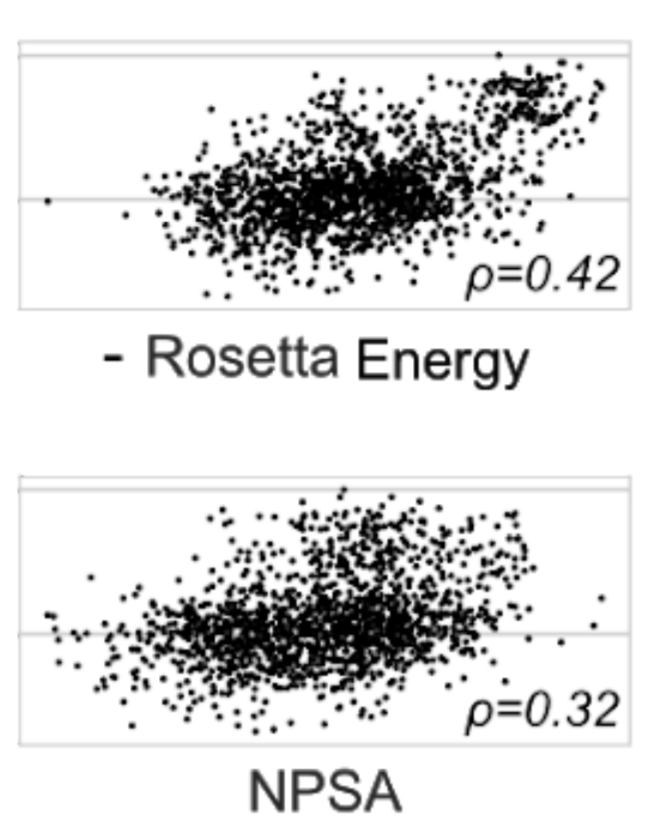

In [21]:
from IPython.display import Image
Image(filename="/tf/notebooks/Capture.PNG")

![](/tf/notebooks/Capture.PNG "name")